# Linear Regression with Tensorflow

This notebook will show how to make a linear regression with the help of the `Tensorflow` library. As an example, a set of OpenStreetMap elements gathered around Bordeaux will be used. The goal of the notebook is to predict the number of contributors for each element, starting from a set of other element characteristics.

## Step 0: module imports

`matplotlib` will be used to plot regression results, `os` is necessary for relative path handling, then `pandas` is used to handle the input dataframe, and of course, `tensorflow` will be needed to do the regression.

In [1]:
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf

## Step 1: data recovering and preparation

The used data describes a set of OSM elements, we admit it is available on the computer.

In [3]:
data = pd.read_csv("/home/rde/data/osm-history/output-extracts/bordeaux-metropole/element-metadata.csv", index_col=0)
data.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2760999, 17)

We have 2760999 individuals in this table, described by 17 different features. One can provide a short extract of this dataset:

In [1]:
data.sample(6).T

NameError: name 'data' is not defined

In this study, we will consider the number of contributors as the output to predict. We select a small set of features as predictors: the number of days between first and last modifications, the number of days since first modification, the number of days during which modifications arised, the last version, the number of change sets and the numbers of autocorrections and corrections.

In [2]:
data_x = data[["lifespan", "n_inscription_days", "n_activity_days", "version", "n_chgset", "n_autocorr", "n_corr"]].values
data_y = data[["n_user"]].values

NameError: name 'data' is not defined

In [6]:
print(data_x.shape)
print(data_y.shape)

(2760999, 7)
(2760999, 1)


As a good practice, we can use the dedicated `sklearn` function to split the dataset into **train** and **test** data.

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2484899, 7)
(276100, 7)
(2484899, 1)
(276100, 1)


## Step 2: Parameter settings

In [9]:
# Parameters
learning_rate = 0.01
training_epochs = 15000
display_step = 50

## Step 3: Prepare the checkpoint creation

In [10]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
make_dir('checkpoints')
make_dir('checkpoints/linreg_osm')

global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')


## Step 4: Tensorflow model design

We need to tensors, *i.e.* one for inputs and one for outputs.

In [11]:
with tf.name_scope("data"):
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")

The linear regression is defined through weights and biases, that are set as tensorflow variables, and injected into the output variable `predictions`. A hidden layer is added to

In [12]:
with tf.name_scope("linear_reg"):
    w = tf.get_variable('weights', [data_x.shape[1], 1], initializer=tf.truncated_normal_initializer())
    b = tf.get_variable('biases', [1], initializer=tf.constant_initializer(0.0))
    predictions = tf.add(tf.matmul(X, w), b)

The cost function is the sum of squares of differences between predictions and true outputs. A regularization term is added to this value.

In [13]:
with tf.name_scope('loss'):
    # loss function + regularization value
    loss = tf.reduce_sum(tf.square(predictions - Y)) + 0.01 * tf.nn.l2_loss(w)

We use Adam optimizer to update the model variable.

In [14]:
with tf.name_scope('train'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

## Step 5: Variable initialization

In [15]:
init = tf.global_variables_initializer()

## Final step: running the model

First we have to open a new session, initialize the variable, and prepare the graph and checkpoint utilities:

In [16]:
session = tf.Session()
session.run(init)

saver = tf.train.Saver()
writer = tf.summary.FileWriter('./graphs/linreg', session.graph)
##### You have to create folders to store checkpoints
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/linreg_osm/checkpoint'))
# if that checkpoint exists, restore from checkpoint
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(session, ckpt.model_checkpoint_path)

initial_step = global_step.eval(session=session)

The model is ready to be trained. We proceed to as many training steps as indicated by the previous parametrization.

In [17]:
costs = list()
weights = list()
biases = list()
print("### Training step ###")
for epoch in range(initial_step, training_epochs):
    session.run(train_op, feed_dict={X: x_train, Y: y_train})
    #Display logs per epoch step
    if (epoch+1) % display_step == 0:
        training_cost, weight, bias = session.run([loss, w, b], feed_dict={X: x_train, Y: y_train})
        print("*** Epoch", '%04d' % (epoch+1), "cost={}\nn_user = {:.3f}*X1 + {:.3f}*X2 + {:.3f}*X3 + {:.3f}*X4 + {:.3f}*X5 + {:.3f}*X6 + {:.3f}*X7 + {:.3f} ***".format(training_cost, weight[0][0], weight[1][0], weight[2][0], weight[3][0], weight[4][0], weight[5][0], weight[6][0], bias[0]))
        costs.append(training_cost)
        weights.append(weight[:,0])
        biases.append(bias[0])
        saver.save(session, 'checkpoints/linreg_osm/osm-linreg', epoch)

### Training step ###
*** Epoch 0050 cost=56405721088.0
n_user = -0.349*X1 + 0.073*X2 + -0.025*X3 + -0.134*X4 + -0.103*X5 + -0.509*X6 + -0.849*X7 + -0.390 ***
*** Epoch 0100 cost=176554400.0
n_user = -0.019*X1 + 0.005*X2 + -0.063*X3 + -0.161*X4 + -0.139*X5 + -0.344*X6 + -0.645*X7 + -0.465 ***
*** Epoch 0150 cost=7448446.0
n_user = 0.004*X1 + 0.001*X2 + -0.064*X3 + -0.158*X4 + -0.139*X5 + -0.302*X6 + -0.621*X7 + -0.470 ***
*** Epoch 0200 cost=4996612.0
n_user = 0.002*X1 + 0.001*X2 + -0.062*X3 + -0.153*X4 + -0.136*X5 + -0.267*X6 + -0.611*X7 + -0.469 ***
*** Epoch 0250 cost=4577138.0
n_user = 0.002*X1 + 0.001*X2 + -0.060*X3 + -0.147*X4 + -0.133*X5 + -0.228*X6 + -0.598*X7 + -0.469 ***
*** Epoch 0300 cost=4170148.5
n_user = 0.002*X1 + 0.001*X2 + -0.058*X3 + -0.141*X4 + -0.130*X5 + -0.187*X6 + -0.584*X7 + -0.468 ***
*** Epoch 0350 cost=3782234.0
n_user = 0.002*X1 + 0.001*X2 + -0.055*X3 + -0.135*X4 + -0.127*X5 + -0.145*X6 + -0.570*X7 + -0.468 ***
*** Epoch 0400 cost=3420019.0
n_user = 0.002*X

*** Epoch 3200 cost=337795.125
n_user = 0.000*X1 + 0.001*X2 + 0.097*X3 + 0.024*X4 + 0.045*X5 + -0.033*X6 + 0.260*X7 + -0.403 ***
*** Epoch 3250 cost=329575.46875
n_user = 0.000*X1 + 0.001*X2 + 0.099*X3 + 0.027*X4 + 0.048*X5 + -0.040*X6 + 0.270*X7 + -0.401 ***
*** Epoch 3300 cost=321794.375
n_user = 0.000*X1 + 0.001*X2 + 0.102*X3 + 0.029*X4 + 0.050*X5 + -0.048*X6 + 0.279*X7 + -0.399 ***
*** Epoch 3350 cost=314510.6875
n_user = 0.000*X1 + 0.001*X2 + 0.105*X3 + 0.031*X4 + 0.053*X5 + -0.056*X6 + 0.287*X7 + -0.397 ***
*** Epoch 3400 cost=307693.15625
n_user = 0.000*X1 + 0.001*X2 + 0.107*X3 + 0.033*X4 + 0.055*X5 + -0.063*X6 + 0.296*X7 + -0.395 ***
*** Epoch 3450 cost=301300.375
n_user = 0.000*X1 + 0.001*X2 + 0.109*X3 + 0.035*X4 + 0.057*X5 + -0.070*X6 + 0.303*X7 + -0.393 ***
*** Epoch 3500 cost=295298.125
n_user = 0.000*X1 + 0.001*X2 + 0.112*X3 + 0.037*X4 + 0.060*X5 + -0.077*X6 + 0.311*X7 + -0.390 ***
*** Epoch 3550 cost=289589.6875
n_user = 0.000*X1 + 0.001*X2 + 0.114*X3 + 0.040*X4 + 0.062*X

*** Epoch 6350 cost=134401.6875
n_user = 0.000*X1 + 0.000*X2 + 0.218*X3 + 0.194*X4 + 0.114*X5 + -0.350*X6 + 0.182*X7 + -0.182 ***
*** Epoch 6400 cost=132387.84375
n_user = 0.000*X1 + 0.000*X2 + 0.220*X3 + 0.197*X4 + 0.114*X5 + -0.354*X6 + 0.176*X7 + -0.177 ***
*** Epoch 6450 cost=130413.8515625
n_user = 0.000*X1 + 0.000*X2 + 0.222*X3 + 0.200*X4 + 0.114*X5 + -0.359*X6 + 0.170*X7 + -0.171 ***
*** Epoch 6500 cost=128472.109375
n_user = 0.000*X1 + 0.000*X2 + 0.224*X3 + 0.204*X4 + 0.114*X5 + -0.363*X6 + 0.164*X7 + -0.166 ***
*** Epoch 6550 cost=126542.3984375
n_user = 0.000*X1 + 0.000*X2 + 0.226*X3 + 0.207*X4 + 0.114*X5 + -0.367*X6 + 0.158*X7 + -0.161 ***
*** Epoch 6600 cost=124673.46875
n_user = 0.000*X1 + 0.000*X2 + 0.227*X3 + 0.211*X4 + 0.114*X5 + -0.372*X6 + 0.153*X7 + -0.156 ***
*** Epoch 6650 cost=122828.078125
n_user = 0.000*X1 + 0.000*X2 + 0.229*X3 + 0.214*X4 + 0.114*X5 + -0.376*X6 + 0.147*X7 + -0.150 ***
*** Epoch 6700 cost=121046.1796875
n_user = 0.000*X1 + 0.000*X2 + 0.231*X3 + 0

*** Epoch 9500 cost=69927.578125
n_user = 0.000*X1 + 0.000*X2 + 0.298*X3 + 0.300*X4 + 0.012*X5 + -0.471*X6 + 0.103*X7 + 0.190 ***
*** Epoch 9550 cost=69369.71875
n_user = 0.000*X1 + 0.000*X2 + 0.298*X3 + 0.298*X4 + 0.009*X5 + -0.468*X6 + 0.108*X7 + 0.197 ***
*** Epoch 9600 cost=68820.375
n_user = 0.000*X1 + 0.000*X2 + 0.299*X3 + 0.297*X4 + 0.006*X5 + -0.465*X6 + 0.113*X7 + 0.204 ***
*** Epoch 9650 cost=68264.0078125
n_user = 0.000*X1 + 0.000*X2 + 0.300*X3 + 0.295*X4 + 0.003*X5 + -0.462*X6 + 0.119*X7 + 0.211 ***
*** Epoch 9700 cost=67687.3125
n_user = 0.000*X1 + 0.000*X2 + 0.300*X3 + 0.293*X4 + -0.000*X5 + -0.459*X6 + 0.124*X7 + 0.218 ***
*** Epoch 9750 cost=67130.484375
n_user = 0.000*X1 + 0.000*X2 + 0.301*X3 + 0.291*X4 + -0.004*X5 + -0.456*X6 + 0.130*X7 + 0.225 ***
*** Epoch 9800 cost=66573.53125
n_user = 0.000*X1 + 0.000*X2 + 0.302*X3 + 0.288*X4 + -0.007*X5 + -0.452*X6 + 0.135*X7 + 0.233 ***
*** Epoch 9850 cost=66014.359375
n_user = 0.000*X1 + 0.000*X2 + 0.302*X3 + 0.286*X4 + -0.010*

*** Epoch 12600 cost=45067.01953125
n_user = 0.000*X1 + 0.000*X2 + 0.305*X3 + 0.152*X4 + -0.147*X5 + -0.245*X6 + 0.442*X7 + 0.603 ***
*** Epoch 12650 cost=44853.69140625
n_user = 0.000*X1 + 0.000*X2 + 0.305*X3 + 0.150*X4 + -0.149*X5 + -0.242*X6 + 0.447*X7 + 0.608 ***
*** Epoch 12700 cost=760858.5
n_user = -0.000*X1 + -0.000*X2 + 0.304*X3 + 0.148*X4 + -0.150*X5 + -0.240*X6 + 0.451*X7 + 0.613 ***
*** Epoch 12750 cost=70542.0625
n_user = 0.000*X1 + 0.000*X2 + 0.304*X3 + 0.146*X4 + -0.151*X5 + -0.237*X6 + 0.455*X7 + 0.618 ***
*** Epoch 12800 cost=44429.40234375
n_user = 0.000*X1 + 0.000*X2 + 0.304*X3 + 0.144*X4 + -0.153*X5 + -0.234*X6 + 0.459*X7 + 0.622 ***
*** Epoch 12850 cost=44158.1640625
n_user = 0.000*X1 + 0.000*X2 + 0.303*X3 + 0.143*X4 + -0.154*X5 + -0.232*X6 + 0.463*X7 + 0.626 ***
*** Epoch 12900 cost=43984.58984375
n_user = 0.000*X1 + 0.000*X2 + 0.303*X3 + 0.141*X4 + -0.156*X5 + -0.229*X6 + 0.467*X7 + 0.631 ***
*** Epoch 12950 cost=43810.04296875
n_user = 0.000*X1 + 0.000*X2 + 0.30

The results are stored into a pandas dataframe and saved onto the file system.

In [18]:
param_history = pd.DataFrame(weights, columns=["lifespan", "n_inscription_days", "n_activity_days", "version", "n_chgset", "n_autocorr", "n_corr"])
param_history["bias"] = biases
param_history["loss"] = costs

if initial_step == 0:
    param_history.to_csv("linreg_osm.csv", index=False)
else:
    param_history.to_csv("linreg_osm.csv", index=False, mode='a', header=False)

Then the data into this `csv` file is recovered. We do not consider the current `param_history` value, as it may represent only the last training steps, if the train just had been restored from a checkpoint. We use the results for plotting purpose.

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


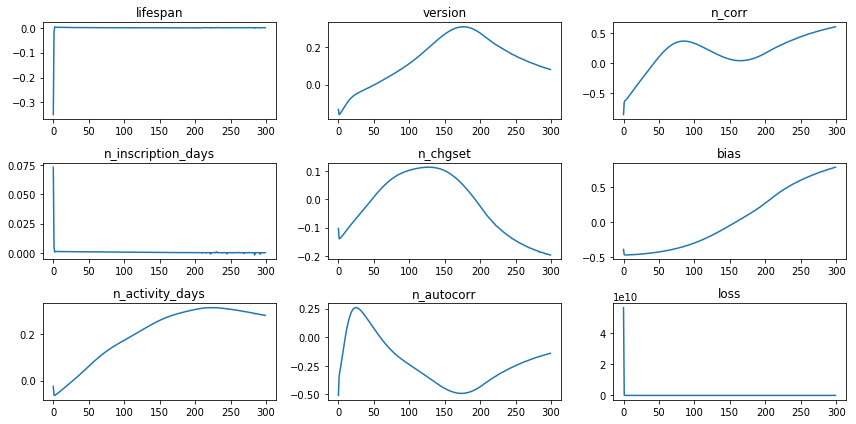

In [19]:
param_history = pd.read_csv("linreg_osm.csv", index_col=False)

#Graphic display
f, ax = plt.subplots(3, 3, figsize=(12,6))
for i in range(param_history.shape[1]):
    ax[i % 3][int(i / 3)].plot(param_history.iloc[:,i])
    ax[i % 3][int(i / 3)].set_title(param_history.columns[i])
f.tight_layout()
f.show()

Then the model is run with test data (this dataset was not used for model training). The goal is to evaluate the correspondance between true value of `y` and the model prediction.

In [20]:
print("### Test step ###")
cost, y_pred = session.run([loss, predictions], feed_dict={X: x_test, Y: y_test})
print("Test cost = {}, i.e. +/- {:.3f} contributor(s) per OSM elements on average".format(cost, math.sqrt(cost/len(y_test))))

### Test step ###
Test cost = 3010.407470703125, i.e. +/- 0.104 contributor(s) per OSM elements on average


A last plot is produced starting from the test step: it shows how good the predictions are.

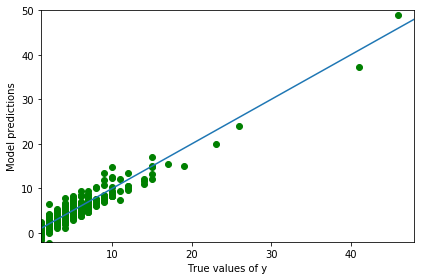

In [21]:
plt.plot(y_test, y_pred, 'go')
output_min, output_max = int(min(y_pred)[0]), int(max(y_pred)[0])
plt.plot(range(output_min, output_max+2), range(output_min, output_max+2))
plt.xlabel("True values of y")
plt.ylabel("Model predictions")
plt.xlim(min(y_test)[0], max(y_test)[0]+2)
plt.ylim(output_min, output_max+2)
plt.tight_layout()
plt.show()

Last the tensorflow session is closed.

In [22]:
session.close()